In [2]:
import itertools
import z3
from golz3 import *
import time

## Forward (sanity check)

In [2]:
# Sanity check: 2x2 grid stays still
solver = z3.Solver()
state = make_life(solver, grid_size=5, time_steps=4)
constrain(solver, state[0], set([(1, 1), (1, 2), (2, 1), (2, 2)]))
solver.check()
model = solver.model()
print_model(model, state)


t = 0
0 0 0 0 0 
0 1 1 0 0 
0 1 1 0 0 
0 0 0 0 0 
0 0 0 0 0 

t = 1
0 0 0 0 0 
0 1 1 0 0 
0 1 1 0 0 
0 0 0 0 0 
0 0 0 0 0 

t = 2
0 0 0 0 0 
0 1 1 0 0 
0 1 1 0 0 
0 0 0 0 0 
0 0 0 0 0 

t = 3
0 0 0 0 0 
0 1 1 0 0 
0 1 1 0 0 
0 0 0 0 0 
0 0 0 0 0 



In [3]:
# Sanity check: 1x3 rotation
solver = z3.Solver()
state = make_life(solver, grid_size=3, time_steps=4)
constrain(solver, state[0], set([(0, 1), (1, 1), (2, 1)]))
solver.check()
model = solver.model()
print_model(model, state)

t = 0
0 1 0 
0 1 0 
0 1 0 

t = 1
0 0 0 
1 1 1 
0 0 0 

t = 2
0 1 0 
0 1 0 
0 1 0 

t = 3
0 0 0 
1 1 1 
0 0 0 



In [4]:
# Sanity check: glider
solver = z3.Solver()
state = make_life(solver, grid_size=6, time_steps=6)
constrain(solver, state[0], set([(0, 1), (1, 2), (2, 0), (2, 1), (2, 2)]))
solver.check()
model = solver.model()
print_model(model, state)


t = 0
0 1 0 0 0 0 
0 0 1 0 0 0 
1 1 1 0 0 0 
0 0 0 0 0 0 
0 0 0 0 0 0 
0 0 0 0 0 0 

t = 1
0 0 0 0 0 0 
1 0 1 0 0 0 
0 1 1 0 0 0 
0 1 0 0 0 0 
0 0 0 0 0 0 
0 0 0 0 0 0 

t = 2
0 0 0 0 0 0 
0 0 1 0 0 0 
1 0 1 0 0 0 
0 1 1 0 0 0 
0 0 0 0 0 0 
0 0 0 0 0 0 

t = 3
0 0 0 0 0 0 
0 1 0 0 0 0 
0 0 1 1 0 0 
0 1 1 0 0 0 
0 0 0 0 0 0 
0 0 0 0 0 0 

t = 4
0 0 0 0 0 0 
0 0 1 0 0 0 
0 0 0 1 0 0 
0 1 1 1 0 0 
0 0 0 0 0 0 
0 0 0 0 0 0 

t = 5
0 0 0 0 0 0 
0 0 0 0 0 0 
0 1 0 1 0 0 
0 0 1 1 0 0 
0 0 1 0 0 0 
0 0 0 0 0 0 



### Forward Edge Cases

In [10]:
# Edge case: Example of where forward can fail (Tenzin: this has implications
# for the results we get from backwards queries too, i.e.: we can get
# incorrect sequences I'm pretty sure).
# This spinner on the bottom should spin indefinitely, so on t=2, it
# should go back to the bottom being set, however instead the solver
# predicts that we die out.
# One solution is to add a constraint on the imaginary boundary cells,
# asserting that they never come alive.
solver = z3.Solver()
state = make_life(solver, grid_size=35, time_steps=3)
constrain(solver, state[0], set([(0, 0), (0, 1), (0, 2)]))

# With this line solver will fail to find solution because we enforce that
# cells outside play area are never used. (i.e.: exception is expected)
constrain_life_boundary(solver, state)

result = solver.check()

try:
    # We expect exception here if constrain_life_boundary is called
    model = solver.model()
    print_model(model, state)
except Exception as e:
    print(e)

model is not available


## Backwards

In [11]:
# Backwards: 3x3 corner
solver = z3.Solver()
state = make_life(solver, grid_size=5, time_steps=2)
constrain(solver, state[-1], set([(0,0)]))
solver.check()
model = solver.model()
print_model(model, state)

t = 0
1 1 1 0 0 
0 1 1 1 1 
1 0 1 0 0 
0 0 1 0 0 
1 0 0 0 0 

t = 1
1 0 0 0 0 
0 0 0 0 0 
0 0 0 0 0 
0 0 0 0 0 
0 0 0 0 0 



In [12]:
# Backwards: smiley
solver = z3.Solver()
state = make_life(solver, grid_size=6, time_steps=4)
constrain(solver, state[-1], set([(0,0)]))
solver.check()
model = solver.model()
print_model(model, state)


t = 0
1 1 0 0 0 0 
1 0 0 0 1 0 
0 0 1 0 1 0 
0 0 0 0 0 1 
1 1 0 1 0 0 
0 0 0 1 0 0 

t = 1
1 1 0 0 0 0 
1 0 0 1 0 0 
0 0 0 1 1 1 
0 1 1 1 1 0 
0 0 1 0 1 0 
0 0 1 0 0 0 

t = 2
1 1 0 0 0 0 
1 1 1 1 0 0 
0 1 0 0 0 1 
0 1 0 0 0 0 
0 0 0 0 1 0 
0 0 0 1 0 0 

t = 3
1 0 0 0 0 0 
0 0 0 0 0 0 
0 0 0 0 0 0 
0 0 0 0 0 0 
0 0 0 0 0 0 
0 0 0 0 0 0 



In [13]:
# Glider discovery
solver = z3.Solver()
state = make_life(solver, grid_size=6, time_steps=4)
for i in range(6):
    for j in range(6):
        solver.add(state[0][i][j] == state[-1][i][j])
solver.add(state[0][1][1] != state[1][1][1])
solver.check()
model = solver.model()
print_model(model, state)

t = 0
1 1 0 0 0 0 
1 1 0 0 1 0 
0 0 1 1 0 1 
0 0 1 0 0 1 
0 1 0 0 0 1 
0 0 1 1 1 0 

t = 1
1 1 0 0 0 0 
1 0 0 1 1 0 
0 0 1 1 0 1 
0 1 1 1 0 1 
0 1 0 0 0 1 
0 0 1 1 1 0 

t = 2
1 1 0 0 0 0 
1 0 0 1 1 0 
0 0 0 0 0 1 
0 1 0 1 0 1 
0 1 0 0 0 1 
0 0 1 1 1 0 

t = 3
1 1 0 0 0 0 
1 1 0 0 1 0 
0 0 1 1 0 1 
0 0 1 0 0 1 
0 1 0 0 0 1 
0 0 1 1 1 0 



In [18]:
# Backwards: big smiley
solver = z3.Solver()
n = 25
state = make_life(solver, grid_size=n, time_steps=3)
constrain(solver, state[-1], set([(5, 5), (5, 8), (7, 5), (7, 8), (8, 6), (8, 7)]))
# for t in range(3):
#     solver.add(sum([state[t][i][j] for j in range(n) for i in range(n)]) <= 20)
solver.check()
model = solver.model()
print_model(model, state)

t = 0
1 0 1 1 1 1 1 0 1 1 0 1 0 0 0 0 1 0 0 0 1 1 1 0 1 
0 0 1 1 0 1 1 1 0 1 1 0 0 0 0 0 0 0 1 1 1 1 0 1 1 
0 0 1 0 1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 1 0 0 1 1 
0 1 0 0 1 0 1 0 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 0 
0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 1 1 1 1 1 0 1 0 0 
1 1 1 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 
0 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0 1 1 1 1 1 1 1 0 0 
0 0 1 0 0 1 1 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 0 0 
0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 0 1 0 0 
0 0 1 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0 1 0 1 0 0 
1 0 1 1 1 1 0 0 0 1 0 1 1 1 0 0 0 1 0 0 0 1 0 1 1 
0 0 0 0 1 1 1 0 1 1 0 1 1 0 1 0 1 1 0 0 1 0 0 1 1 
1 0 0 1 1 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 
1 1 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 1 0 
0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 1 1 1 0 1 1 1 0 1 0 
1 0 0 1 1 0 0 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 0 0 0 
0 1 1 0 1 0 0 0 1 1 1 0 0 0 0 1 1 1 1 0 0 1 0 1 0 
1 0 1 1 0 0 1 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 1 0 
0 0 0 1 1 0 0 0 1 1 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 
0 1 1 0 0 1 1 1 1 1 1 0 0

## Garden of Eden

In [7]:
# Known GoE from wikipedia

pat = """
010110110010
001011101110
001101110101
010111011101
111110011110
011011101001
011101010010
011011100110
101110111010
100110010101
000000000010
000000000000
"""

solver = z3.Solver()
state = make_life(solver, grid_size = 14, time_steps = 2)
on = set([(i + 1, j + 1) for i, row in enumerate(pat.split()) for j, c in enumerate(row) if c == '1'])
constrain(solver, state[-1], on)
assert(solver.check() == z3.unsat)
from frames import Frames
Frames([[[1 if pat.split()[i][j] == '1' else 0 for j in range(12)] for i in range(12)]]).save('garden_of_eden.golz3')

In [5]:
# Exhaustive search for Gardens of Eden
def all_grids(n):
    mask = 0
    while mask < 1 << (n * n):
        on = set([(i, j) for i in range(n) for j in range(n) if mask & (1 << (i * n + j))])
        yield on
        mask += 1

n = 3

start = time.perf_counter()
for grid in all_grids(n):
    solver = z3.Solver()
    state = make_life(solver, grid_size=n+2, time_steps=2)
    offset_grid = set([(i + 1, j + 1) for i, j in grid])
    constrain(solver, state[-1], offset_grid)
    if solver.check() == z3.unsat:
        # If UNSAT it means we've found a Garden of Eden. At the scales we should be
        # able to feasibly run this problem at it probably means we've done something
        # wrong if we can find a Garden of Eden lol.
        print(f"Garden of Eden found for {grid}")
        model = solver.model()
        print_model(model, state)

end = time.perf_counter()

naive_exhaustive_goe_time_s = end - start
print(f"Time for naive exhaustive GOE search: {naive_exhaustive_goe_time_s} s")

Time for naive exhaustive GOE search: 36.828078099992126 s


In [6]:
# Incremental exhaustive search

N = 3

def next(i, j, n):
    """
    Scans through coordinates row-wise (i.e.: left to right,
    then down to next row if at end of current row).
    """
    j += 1
    if j == n:
        i += 1
        j = 0
    return i, j

def remaining_grid(n, i, j):
    """
    Return list of coordinates representing cells at the coordinate
    (i, j) and past (following `next` traversal) in
    grid of size n x n.
    """
    cells = []
    while i < n:
        cells.append((i, j))
        i, j = next(i, j, n)
    return cells

def traverse(n):
    yield []
    def visit(n, i, j):
        next_i, next_j = next(i, j, n)
        if next_i != n:
            yield from visit(n, next_i, next_j)

        if next_i == n:
            yield [(i, j, 1)]
        else:
            yield [(i, j, 1)] + list(map(lambda pos: pos + (0,), remaining_grid(n, next_i, next_j)))
            yield from visit(n, next_i, next_j)
    yield from visit(n, 0, 0)

solver = z3.Solver()
state = make_life(solver, grid_size=N+2, time_steps=2)
end = state[-1]
for i, j in remaining_grid(N, 0, 0):
    solver.push()
    solver.add(end[i][j] == 0)

start = time.perf_counter()
for updates in traverse(N):
    for _ in updates:
        solver.pop()
    for i, j, val in updates:
        solver.push()
        solver.add(end[i + 1][j + 1] == val)
    if solver.check() == z3.unsat:
        print(f"no solution")
end = time.perf_counter()

push_pop_goe_time_s = end - start
print(f"Completed push/pop solve in {push_pop_goe_time_s} s")

Completed push/pop solve in 7.079877499956638 s


Text(0.5, 1.0, 'Garden of Eden Search Time')

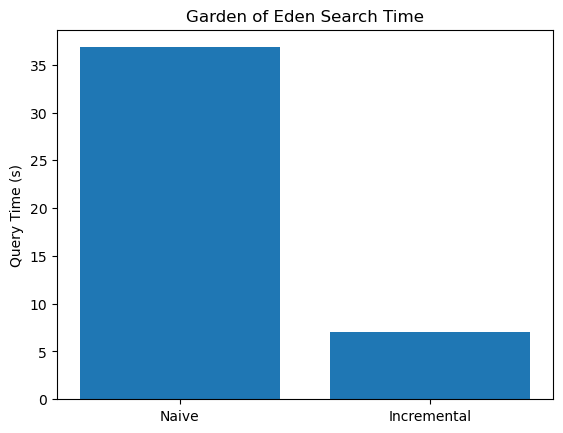

In [8]:
# Graph results of naive vs. push/pop query
import matplotlib.pyplot as plt

plt.bar(["Naive", "Incremental"], [naive_exhaustive_goe_time_s, push_pop_goe_time_s])
plt.ylabel("Query Time (s)")
plt.title("3x3 Garden of Eden Search Time")

## Rule synthesis